# Analyzing the Data

# Data preparation

In [1]:
#import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


import ROOT;
#import lumiere as lm
#lm.loadstyle(True);

from sklearn.metrics import roc_auc_score, roc_curve

def ams_score(x, y, w, cut):
# Calculate Average Mean Significane as defined in ATLAS paper
#    -  approximative formula for large statistics with regularisation
# x: array of truth values (1 if signal)
# y: array of classifier result
# w: array of event weights
# cut
    t = y > cut 
    s = np.sum((x[t] == 1)*w[t])
    b = np.sum((x[t] == 0)*w[t])
    return s/np.sqrt(b+10.0)

def find_best_ams_score(x, y, w):
# find best value of AMS by scanning cut values; 
# x: array of truth values (1 if signal)
# y: array of classifier results
# w: array of event weights
#  returns 
#   ntuple of best value of AMS and the corresponding cut value
#   list with corresponding pairs (ams, cut) 
# ----------------------------------------------------------
    ymin=min(y) # classifiers may not be in range [0.,1.]
    ymax=max(y)
    nprobe=200    # number of (equally spaced) scan points to probe classifier 
    amsvec= [(ams_score(x, y, w, cut), cut) for cut in np.linspace(ymin, ymax, nprobe)] 
    maxams=sorted(amsvec, key=lambda lst: lst[0] )[-1]
    return maxams, amsvec




def printScore(model):
    try:
        pred_clf = model.predict_proba(x_test)[:, 1]
    except:
        pred_clf = model.predict(x_test)
        pred_clf = pred_clf.reshape((pred_clf.shape[0],))

    auc = roc_auc_score(y_test, pred_clf, sample_weight=weights_test)
    print('AUC:', auc)
    bs = find_best_ams_score(y_test, pred_clf, weights_test)
    print('AMS:', bs[0][0])
    print('AMS total:', bs[0][0]*np.sqrt(50))



def plotLossAccuracy(history):
    # Get training and validation loss/accuracy values from history
    loss_training = history.history['loss']
    loss_validation = history.history['val_loss']
    accuracy_training = history.history['accuracy']
    accuracy_validation = history.history['val_accuracy']


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
    
    ax1.plot(loss_training, '-', label='training')
    ax1.plot(loss_validation, '-', label='validation')
    ax1.legend(title='loss')
    ax1.set_xlabel('epoch')
    
    ax2.plot(accuracy_training, '-', label='training')
    ax2.plot(accuracy_validation, '-', label='validation')
    ax2.legend(title='accuracy')
    ax2.set_xlabel('epoch')

    plt.show()


def plotAMS(history):
    # Get training and validation loss/accuracy values from history
    ams_training = history.history['ams_metric']
    ams_validation = history.history['val_ams_metric']
    

    fig, ax1 = plt.subplots(1,1, figsize=(10, 8))
    
    #ax1.plot(ams_training, 'o--', label='training')
    ax1.plot(ams_validation, '-', label='validation')
    ax1.legend(title='AMS')
    ax1.set_xlabel('epoch')
    
    plt.show()

Welcome to JupyROOT 6.28/10


## Read-in & to Pandas

In [2]:
'''
input_columns = ['DER_deltaeta_jet_jet', 'DER_deltar_tau_lep', 'DER_lep_eta_centrality', 'DER_mass_MMC', 'DER_mass_jet_jet', 
                 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_met_phi_centrality', 'DER_prodeta_jet_jet', 'DER_pt_h', 
                 'DER_pt_ratio_lep_tau', 'DER_pt_tot', 'DER_sum_pt', 'PRI_jet_all_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 
                 'PRI_jet_leading_pt', 'PRI_jet_num', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt', 
                 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_lep_pt', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_tau_eta', 'PRI_tau_phi', 
                 'PRI_tau_pt', 'transverse_lepton_jet_mass']
'''

input_columns = ['DER_deltaeta_jet_jet',
                 'DER_deltar_tau_lep',
                 'DER_lep_eta_centrality',
                 'DER_mass_MMC',
                 'DER_mass_jet_jet', 
                 'DER_mass_transverse_met_lep',
                 'DER_mass_vis', 
                 'DER_met_phi_centrality', 
                 'DER_prodeta_jet_jet', 
                 'DER_pt_h', 
                 'DER_pt_ratio_lep_tau',
                 'DER_pt_tot', 
                 'DER_sum_pt',
                 'PRI_jet_all_pt',
                 'PRI_jet_leading_eta', 
                 'PRI_jet_leading_phi', 
                 'PRI_jet_leading_pt',
                 'PRI_jet_num',
                 'PRI_jet_subleading_eta',
                 'PRI_jet_subleading_phi',   'PRI_jet_subleading_pt', 
                 'PRI_lep_eta', 
                 'PRI_lep_phi', 
                 'PRI_lep_pt', 
                 'PRI_met',
                 'PRI_met_sumet', 
                 'PRI_tau_eta', 
                 'PRI_tau_pt',
                 'transverse_lepton_jet_mass']

print(len(input_columns))

29


In [3]:
RDF = ROOT.ROOT.RDataFrame

signal_tree_name = 'signal'
background_tree_name = 'background'
test_tree_name = 'validation'
file_name = 'atlas-higgs-challenge-2014-v2_part.root'

rdf_signal = RDF(signal_tree_name, file_name)
rdf_bkg = RDF(background_tree_name, file_name)
rdf_test = RDF(test_tree_name, file_name)

reconstruct_transverse_lepton_jet_mass = '''

float lep_px = PRI_lep_pt * TMath::Cos(PRI_lep_phi);
float lep_py = PRI_lep_pt * TMath::Sin(PRI_lep_phi);
float jet_px = PRI_jet_leading_pt * TMath::Cos(PRI_jet_leading_phi);
float jet_py = PRI_jet_leading_pt * TMath::Sin(PRI_jet_leading_phi);

//calculate angle between jet and lepton
float cos_theta = (lep_px*jet_px + lep_py*jet_py) / PRI_lep_pt / PRI_jet_leading_pt;

return PRI_lep_pt * PRI_jet_leading_pt * (1 - cos_theta);
'''

#insertion
rdf_signal = rdf_signal.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)
rdf_bkg = rdf_bkg.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)
rdf_test = rdf_test.Define('transverse_lepton_jet_mass', reconstruct_transverse_lepton_jet_mass)

# label classification to int values
rdf_test = rdf_test.Define('IntLabel', '''
const char ch = Label[0];
const char s = 's';
if(ch == s){
    return 1;
}
else{
    return 0;
}
''')


df_signal = pd.DataFrame(rdf_signal.AsNumpy())
df_bg = pd.DataFrame(rdf_bkg.AsNumpy())
df_test = pd.DataFrame(rdf_test.AsNumpy())


In [4]:
for tdf in [df_signal, df_bg, df_test]:
    tdf['PRI_lep_eta'] = tdf['PRI_lep_eta'].abs()
    tdf['PRI_tau_eta'] = tdf['PRI_tau_eta'].abs()

## concatination, shuffle and split

In [5]:
from sklearn.utils import shuffle;
from sklearn.model_selection import train_test_split;

#input feature arrays
vars_signal = df_signal[input_columns].to_numpy()
vars_bg = df_bg[input_columns].to_numpy()
vars_test = df_test[input_columns].to_numpy()

inputs = np.concatenate([vars_signal, vars_bg])

#weights
weight_signal = df_signal['Weight'].to_numpy()
weight_bg = df_bg['Weight'].to_numpy()
weights = np.concatenate([weight_signal, weight_bg])
weights = weights.reshape((weights.shape[0],))

weights_test = df_test['Weight'].to_numpy()


# target classifictionation (1:signal / 0: background)
y_signal = np.ones((vars_signal.shape[0], ))
y_bg = np.zeros((vars_bg.shape[0], ))

targets = np.concatenate([y_signal, y_bg])

# for test dataset there is already a classification; convert to int
y_test = df_test.IntLabel.to_numpy()


# shuffle 
inputs, targets, weights = shuffle(inputs, targets, weights)


# training and validation split  (80, 20)
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(inputs, targets, weights, test_size=0.2)
#x_train, y_train = inputs, targets

## StandardScaling 

In [6]:
from sklearn.preprocessing import StandardScaler;
 
scaler = StandardScaler()
scaler.fit(x_train) #set up only on train data
 
# tranformation applied to all
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(vars_test)

### SMOTE

In [7]:
#%pip install imbalanced-learn

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)


In [9]:
#from imblearn.over_sampling import ADASYN
#ada = ADASYN(random_state=0)
#x_train, y_train = ada.fit_resample(x_train, y_train)

## PCA

In [10]:
from sklearn.decomposition import PCA

x_train_pre = x_train

#pca = PCA(n_components=22)
#pca.fit(x_train)

#x_train = pca.transform(x_train)
#x_val = pca.transform(x_val)
#x_test = pca.transform(x_test)

## DNN

$$
AMS = \sqrt{2((s+b+b_r) \log(1+\frac{s}{s+b_r})-s)}
$$

Here:
- $s, b$: unnormalised true positive and false positive rates, respectively
- $b_r = 10$ is the constant regularisation term


In [15]:
from tensorflow.keras.metrics import Metric
from tensorflow.keras.metrics import AUC


def ams_metric_exact(y_true, y_pred, weights):
    
    s = np.sum(y_true * np.round(y_pred) * weights)
    b = np.sum((1 - y_true) * np.round(1 - y_pred) * weights)
    b_r = 10.0
    ams = np.sqrt(2 * ((s + b + b_r) * np.log(1 + s / (b + b_r)) - s))
    return ams

def ams_scorer_wrapper(w):
    def my_find_best_ams_score(x, y):
        ymax=max(y)
        nprobe=200    # number of (equally spaced) scan points to probe classifier 
        amsvec= [(ams_score(x, y, w, cut), cut) for cut in np.linspace(ymin, ymax, nprobe)] 
        maxams=sorted(amsvec, key=lambda lst: lst[0] )[-1]
        return maxams, amsvec
    return my_find_best_ams_score


#### training function

In [12]:

# Training function
def train(model, epochs=10, batch_size=128, learning_rate=1e-3, verbose="auto", callbacks=None):
    
    
    # Define loss function, optimizer algorithm and validation metrics
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        #metrics=['accuracy', AUC],
        metrics=['accuracy'],
    )
    
    # Print summary of the model
    model.summary()
    
    # Train model

    #currently including the weights th oest the new metric
    #history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
    #                     verbose=verbose, callbacks=callbacks, validation_data=(x_val, y_val))
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                         verbose=verbose,  validation_data=(x_val, y_val), callbacks=callbacks)
        
    
    return history


### model

In [13]:
import tensorflow as tf;
from tensorflow.keras import layers, models, optimizers;
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping


# Define the DNN model
def buildModel():
    model = models.Sequential()
    
    # input
    model.add(layers.Input(shape=(x_train.shape[1],)))
    
    # hidden
    model.add(layers.Dense(2*128, activation='relu', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(2*128, activation='relu', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))    
    model.add(layers.Dense(2*128, activation='relu', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128, activation='sigmoid', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128, activation='relu', kernel_initializer='glorot_normal'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='glorot_normal'))
    
    
    # output
    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
    
    return model


## execution

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,833 (753.25 KB)

 Trainable params: 192,833 (753.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.5049 - loss: 0.7347 - val_accuracy: 0.6652 - val_loss: 0.6847
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.5173 - loss: 0.7073 - val_accuracy: 0.6475 - val_loss: 0.6813
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.5389 - loss: 0.6927 - val_accuracy: 0.6409 - val_loss: 0.6705
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.5807 - loss: 0.6730 - val_accuracy: 0.6521 - val_loss: 0.6372
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.6281 - loss: 0.6437 - val_accuracy: 0.6768 - val_loss: 0.6027
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.6814 - loss: 0.6044 - val_accuracy: 0.6884 - val_loss: 0.5905
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.7174 - loss: 0.5732 - val_accuracy: 0.7078 - val_loss: 0.5741
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.7312 - loss: 0.5593 - val_accu

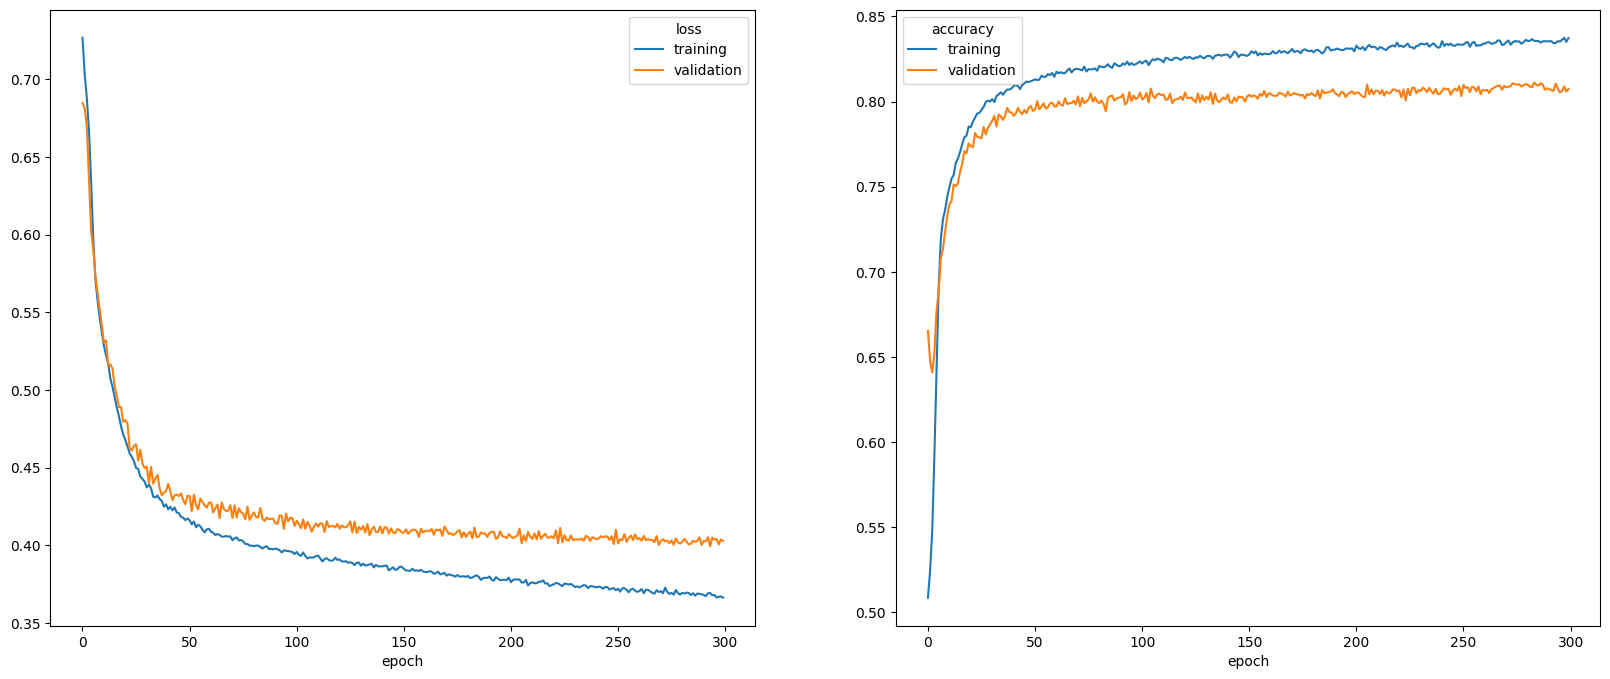

In [14]:
name = 'new_sigmoid_auc_luck_22'

model = buildModel()

callbacks = [ModelCheckpoint(filepath=f'storage/{name}.keras', save_best_only=True), 
            CSVLogger(f'storage/{name}_training.log')
          ]
        

history = train(model, epochs=300, batch_size=4*1024, learning_rate=2e-4, callbacks=callbacks)

printScore(model)
plotLossAccuracy(history)


In [ ]:
ams_metric_exact(y_test, model.predict(x_test), weights_test)

1280/1280 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step


In [ ]:
othermodel = buildModel()

othermodel.load_weights('storage/model_sigmoid_with_auc_scorer_weights_2.6ams.weights.h5')
#othermodel.load_weights('storage/model_sigmoid_weights_2.6ams.weights.h5')
printScore(othermodel)

In [16]:
from keras import saving

#test = saving.load_model('the25model.keras')
test = saving.load_model('storage/new_sigmoid_auc_luck_22.keras')
printScore(test)

1280/1280 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
AUC: 0.9275332462384565
AMS: 0.7391815598268486
AMS total: 5.226802934816144


In [ ]:
ams_metric_exact(y_test, test.predict(x_test), weights_test)

1280/1280 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step


In [ ]:
#test.summary()